# Spaceship Titanic: Feature Selection
## Imports

In [1]:
import warnings
from pathlib import Path
from pprint import pprint
from typing import cast

import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import pandas as pd
from IPython.display import display
from scipy.stats import chisquare
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.inspection import permutation_importance
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

In [2]:
warnings.simplefilter(action="ignore", category=FutureWarning)

## Read data

In [3]:
data_dir = Path.cwd().parent / "input" / "spaceship-titanic"
assert data_dir.exists(), f"directory doesn't exist: {data_dir}"

In [4]:
# Training data (Imputed)
df_train = pd.read_csv(
    data_dir / "train_imputed.csv",
    index_col="PassengerId",
    dtype={"CompCntReduced": pd.CategoricalDtype(categories=["0", "1", "2", "3+"], ordered=True)},
).assign(CompCntReduced=lambda x: x.CompCntReduced.cat.codes)
df_train.head(10)

,Alone,CompCntReduced,HomePlanetOrd,CryoSleep,CabinDeckOrd,CabinPort,DestinationOrd,DiscretizedAge4,DiscretizedAge5,VIP,PosRoomService,PosFoodCourt,PosShoppingMall,PosSpa,PosVRDeck,PTTotalSpent,Transported
PassengerId,,,,,,,,,,,,,,,,,
0001_01,True,0,1,False,0,True,2,3,3,False,False,False,False,False,False,-1.140331,False
0002_01,True,0,0,False,3,False,2,1,2,False,True,True,True,True,True,0.576497,True
0003_01,False,1,1,False,5,False,2,3,4,True,True,True,False,True,True,1.501611,False
0003_02,False,1,1,False,5,False,2,2,3,False,False,True,True,True,True,1.242461,False
0004_01,True,0,0,False,3,False,2,0,0,False,True,True,True,True,True,0.704061,True
0005_01,True,0,0,False,3,True,1,3,4,False,False,True,False,True,False,0.592626,True
0006_01,False,1,0,False,3,False,2,1,2,False,True,True,True,False,False,0.828008,True
0006_02,False,1,0,True,4,False,2,2,2,False,False,False,False,False,False,-1.140331,True
0007_01,True,0,0,False,3,False,2,2,3,False,False,True,True,True,False,0.681374,True


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8693 entries, 0001_01 to 9280_02
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Alone            8693 non-null   bool   
 1   CompCntReduced   8693 non-null   int8   
 2   HomePlanetOrd    8693 non-null   int64  
 3   CryoSleep        8693 non-null   bool   
 4   CabinDeckOrd     8693 non-null   int64  
 5   CabinPort        8693 non-null   bool   
 6   DestinationOrd   8693 non-null   int64  
 7   DiscretizedAge4  8693 non-null   int64  
 8   DiscretizedAge5  8693 non-null   int64  
 9   VIP              8693 non-null   bool   
 10  PosRoomService   8693 non-null   bool   
 11  PosFoodCourt     8693 non-null   bool   
 12  PosShoppingMall  8693 non-null   bool   
 13  PosSpa           8693 non-null   bool   
 14  PosVRDeck        8693 non-null   bool   
 15  PTTotalSpent     8693 non-null   float64
 16  Transported      8693 non-null   bool   
dtypes: bool(10

In [6]:
assert df_train.isna().sum().eq(0).all()

In [7]:
X_train = df_train.drop(columns="Transported")
y_train = df_train["Transported"]

## Univariate feature selection

### Feature selection with chi-square for scoring

In [8]:
# This makes sense only for categorical variables. This is why `PTTotalSpent`
# is excluded.
selector = SelectKBest(
    chi2,
    k="all",  # pyright: ignore [reportArgumentType]
).fit(X_train.drop(columns="PTTotalSpent"), y_train)
selector = cast(SelectKBest, selector)

In [9]:
# Compute scores
pvalues = cast(npt.ArrayLike, selector.pvalues_)
scores = -np.log10(pvalues)
scores /= scores.max()

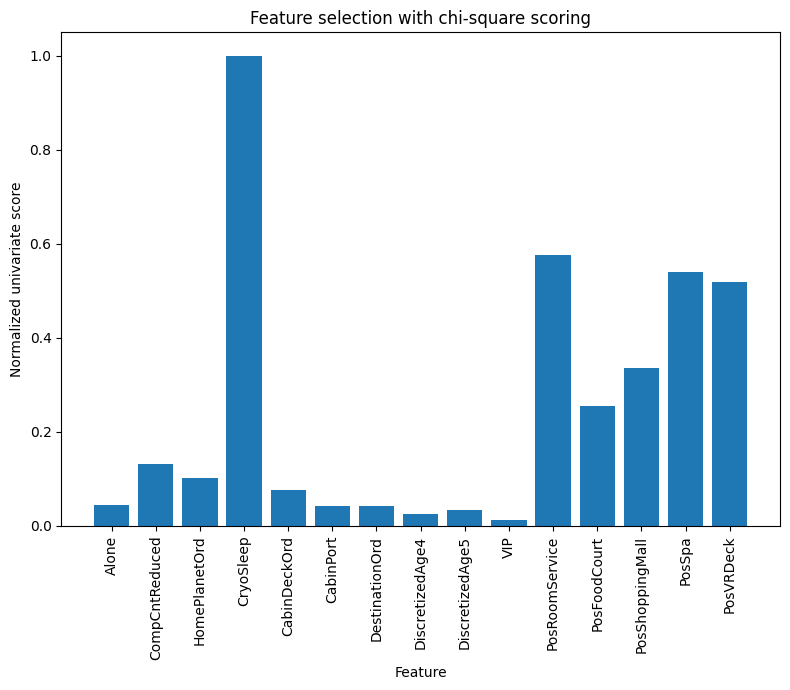

,PValue,Score
Feature,,
Alone,1.290309e-12,0.044846
CompCntReduced,1.620047e-35,0.131229
HomePlanetOrd,1.634373e-27,0.101039
CryoSleep,7.729876e-266,1.000000
CabinDeckOrd,5.339346e-21,0.076468
CabinPort,4.520916e-12,0.042792
DestinationOrd,9.912190e-12,0.041506
DiscretizedAge4,2.563412e-07,0.024862
DiscretizedAge5,1.160803e-09,0.033704


In [10]:
# Visualize results

# Plot scores
fig = plt.figure(figsize=(8.0, 7.0), layout="tight")
ax = fig.add_subplot()
x = np.arange(scores.size)
ax.bar(x, scores)
ax.set_xticks(x, labels=selector.feature_names_in_)
ax.tick_params(axis="x", labelrotation=90.0)
ax.set_xlabel("Feature")
ax.set_ylabel("Normalized univariate score")
ax.set_title("Feature selection with chi-square scoring")
plt.show()

# Display scores table
scores_df = pd.DataFrame(
    data={
        "Feature": selector.feature_names_in_,
        "PValue": pvalues,
        "Score": scores,
    }
).set_index("Feature")
display(scores_df)

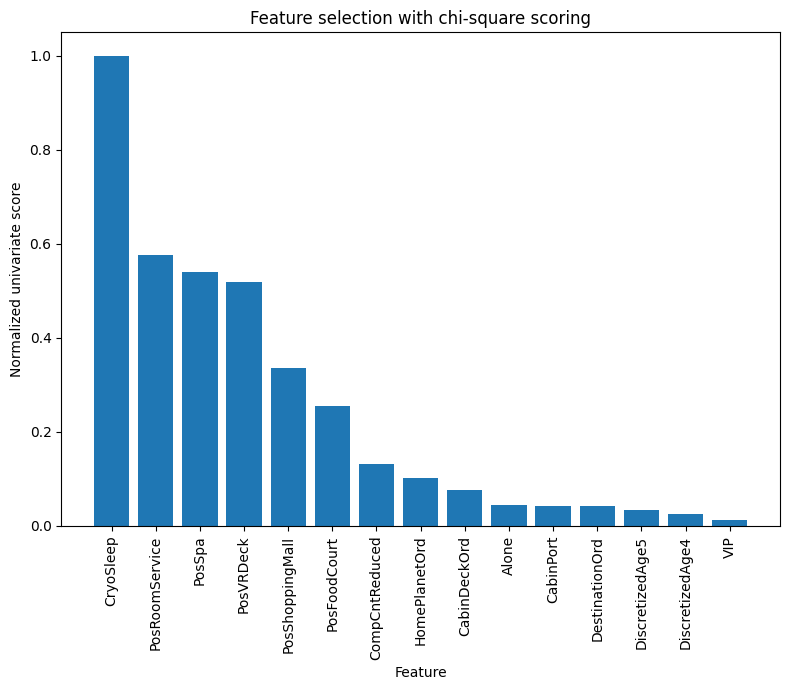

,PValue,Score
Feature,,
CryoSleep,7.729876e-266,1.000000
PosRoomService,1.323365e-153,0.576656
PosSpa,8.771427e-144,0.539610
PosVRDeck,2.173978e-138,0.519263
PosShoppingMall,1.078385e-89,0.335584
PosFoodCourt,1.933636e-68,0.255415
CompCntReduced,1.620047e-35,0.131229
HomePlanetOrd,1.634373e-27,0.101039
CabinDeckOrd,5.339346e-21,0.076468


In [11]:
# Same thing, but order by score
scores_df = scores_df.sort_values(by="Score", ascending=False)

fig = plt.figure(figsize=(8.0, 7.0), layout="tight")
ax = fig.add_subplot()
ax.bar(scores_df.index, scores_df["Score"])
ax.tick_params(axis="x", labelrotation=90.0)
ax.set_xlabel("Feature")
ax.set_ylabel("Normalized univariate score")
ax.set_title("Feature selection with chi-square scoring")
plt.show()

display(scores_df)

In [12]:
# How to reproduce the above results using scipy
# Perform the same calculation for `Alone`
observed = df_train.loc[df_train["Alone"], "Transported"].value_counts().sort_index()
expected = df_train["Transported"].value_counts(normalize=True).sort_index() * observed.sum()
chi2_res = chisquare(observed, f_exp=expected)

In [13]:
# p-value
print(f"scipy       : {chi2_res.pvalue}")
print(f"scikit-learn: {selector.pvalues_[0]}")  # pyright: ignore [reportOptionalSubscript]

scipy       : 1.2903086163392207e-12
scikit-learn: 1.2903086163392207e-12


In [14]:
# Test statistic
print(f"scipy       : {chi2_res.statistic}")
print(f"scikit-learn: {selector.scores_[0]}")

scipy       : 50.34389532341271
scikit-learn: 50.34389532341271


### Feature selection with mutual information for scoring

In [15]:
selector = SelectKBest(
    mutual_info_classif,
    k="all",  # pyright: ignore [reportArgumentType]
).fit(X_train, y_train)
selector = cast(SelectKBest, selector)

In [16]:
# Normalized mutual information
mi = cast(npt.ArrayLike, selector.scores_)
mi /= np.max(mi)

mi_df = (
    pd.DataFrame(data={"Feature": selector.feature_names_in_, "MI": mi})
    .set_index("Feature")
    .sort_values(by="MI", ascending=False)
)

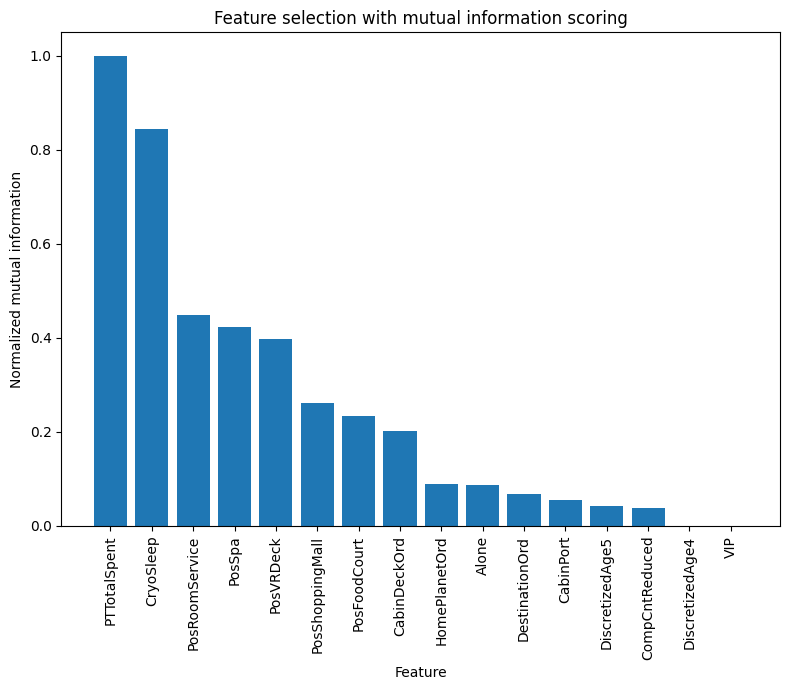

,MI
Feature,
PTTotalSpent,1.000000
CryoSleep,0.845377
PosRoomService,0.449253
PosSpa,0.423151
PosVRDeck,0.396954
PosShoppingMall,0.261033
PosFoodCourt,0.234159
CabinDeckOrd,0.202972
HomePlanetOrd,0.089066


In [17]:
# Visualize results

# Plot mutual information
fig = plt.figure(figsize=(8.0, 7.0), layout="tight")
ax = fig.add_subplot()
ax.bar(mi_df.index, mi_df["MI"])
ax.tick_params(axis="x", labelrotation=90.0)
ax.set_xlabel("Feature")
ax.set_ylabel("Normalized mutual information")
ax.set_title("Feature selection with mutual information scoring")
plt.show()

# Display mutual information table
display(mi_df)

### Compare model performance

In [18]:
feature_names = [
    # "Alone",
    "CompCntReduced",
    "HomePlanetOrd",
    "CryoSleep",
    "CabinDeckOrd",
    "CabinPort",
    "DestinationOrd",
    # "DiscretizedAge4",
    "DiscretizedAge5",
    "VIP",
    "PosRoomService",
    "PosFoodCourt",
    "PosShoppingMall",
    "PosSpa",
    "PosVRDeck",
    "PTTotalSpent",
]
X = df_train[feature_names]
y = df_train["Transported"]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=333)

In [19]:
feature_sets = []
accs = []
f1_scores = []

max_features = len(feature_names)
for num_features in range(1, max_features + 1):
    selector = SelectKBest(mutual_info_classif, k=num_features).fit(X_train, y_train)
    selector = cast(SelectKBest, selector)

    idx = selector.get_support(indices=True)
    feature_set = selector.feature_names_in_[idx]
    feature_sets.append(feature_set)

    X_train_new = selector.transform(X_train)
    X_test_new = selector.transform(X_test)

    clf = GradientBoostingClassifier(random_state=333).fit(X_train_new, y_train)
    clf = cast(GradientBoostingClassifier, clf)

    acc = clf.score(X_test_new, y_test)
    accs.append(acc)

    y_pred = clf.predict(X_test_new)
    f1 = f1_score(y_test, y_pred, average="weighted")
    f1_scores.append(f1)

In [20]:
metrics_df = pd.DataFrame(
    data={
        "NumFeatures": np.arange(1, max_features + 1),
        "Accuracy": accs,
        "F1Score": f1_scores,
    },
).set_index("NumFeatures")

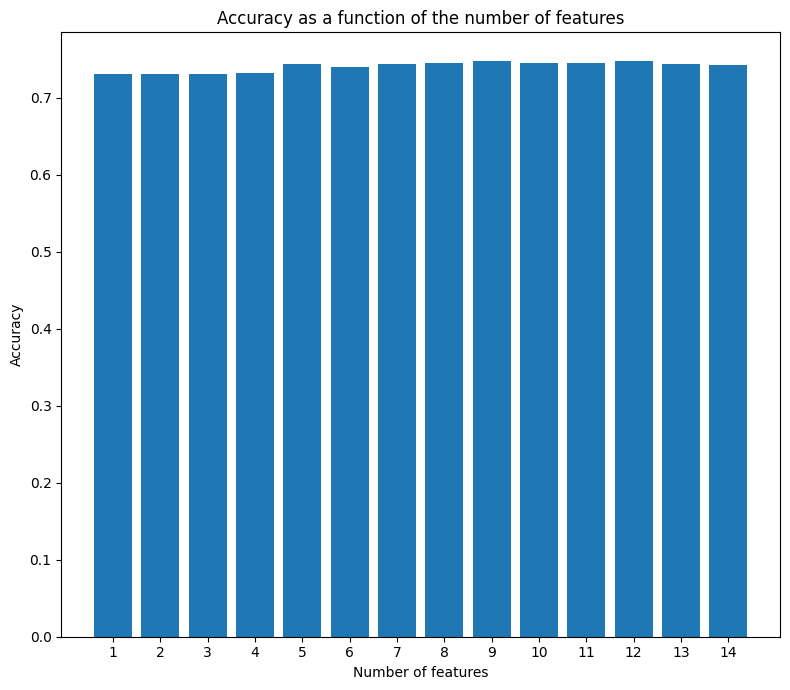

,Accuracy
NumFeatures,
1,0.730451
2,0.730911
3,0.730911
4,0.732291
5,0.743330
6,0.739190
7,0.743330
8,0.744710
9,0.747470


In [21]:
fig = plt.figure(figsize=(8.0, 7.0), layout="tight")
ax = fig.add_subplot()
ks = np.arange(1, max_features + 1)
ax.bar(ks, accs)
ax.set_xticks(ks)
ax.set_xlabel("Number of features")
ax.set_ylabel("Accuracy")
ax.set_title("Accuracy as a function of the number of features")
plt.show()

display(metrics_df[["Accuracy"]])

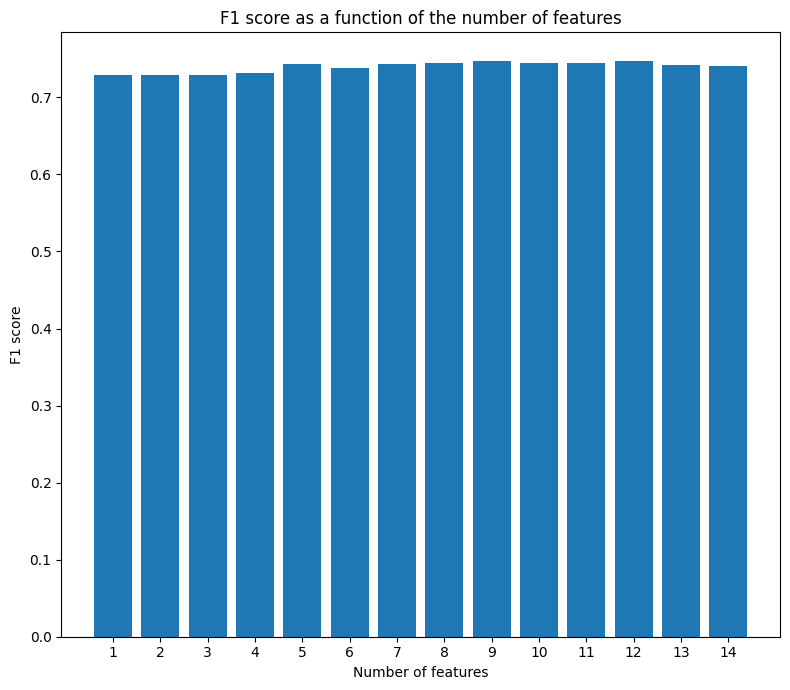

,F1Score
NumFeatures,
1,0.729060
2,0.729431
3,0.729394
4,0.730980
5,0.742873
6,0.738513
7,0.743020
8,0.744246
9,0.747030


In [22]:
fig = plt.figure(figsize=(8.0, 7.0), layout="tight")
ax = fig.add_subplot()
ax.bar(ks, f1_scores)
ax.set_xticks(ks)
ax.set_xlabel("Number of features")
ax.set_ylabel("F1 score")
ax.set_title("F1 score as a function of the number of features")
plt.show()

display(metrics_df[["F1Score"]])

In [23]:
metrics_df = metrics_df.sort_values(by=["Accuracy", "F1Score"], ascending=[False, False])
metrics_df

,Accuracy,F1Score
NumFeatures,,
9,0.747470,0.747030
12,0.747470,0.746970
11,0.745630,0.745039
10,0.745170,0.744696
8,0.744710,0.744246
7,0.743330,0.743020
5,0.743330,0.742873
13,0.743330,0.742355
14,0.742410,0.741215


In [24]:
top_5 = metrics_df.iloc[:5, :]
for i in top_5.index.to_numpy() - 1:
    print(f"Number of features: {i + 1}")
    print("Feature set:")
    pprint(feature_sets[i].tolist())

Number of features: 9
Feature set:
['HomePlanetOrd',
 'CryoSleep',
 'CabinDeckOrd',
 'PosRoomService',
 'PosFoodCourt',
 'PosShoppingMall',
 'PosSpa',
 'PosVRDeck',
 'PTTotalSpent']
Number of features: 12
Feature set:
['CompCntReduced',
 'HomePlanetOrd',
 'CryoSleep',
 'CabinDeckOrd',
 'DestinationOrd',
 'DiscretizedAge5',
 'PosRoomService',
 'PosFoodCourt',
 'PosShoppingMall',
 'PosSpa',
 'PosVRDeck',
 'PTTotalSpent']
Number of features: 11
Feature set:
['CompCntReduced',
 'HomePlanetOrd',
 'CryoSleep',
 'CabinDeckOrd',
 'DiscretizedAge5',
 'PosRoomService',
 'PosFoodCourt',
 'PosShoppingMall',
 'PosSpa',
 'PosVRDeck',
 'PTTotalSpent']
Number of features: 10
Feature set:
['HomePlanetOrd',
 'CryoSleep',
 'CabinDeckOrd',
 'VIP',
 'PosRoomService',
 'PosFoodCourt',
 'PosShoppingMall',
 'PosSpa',
 'PosVRDeck',
 'PTTotalSpent']
Number of features: 8
Feature set:
['CryoSleep',
 'CabinDeckOrd',
 'PosRoomService',
 'PosFoodCourt',
 'PosShoppingMall',
 'PosSpa',
 'PosVRDeck',
 'PTTotalSpent']


## Tree-based feature selection

In [25]:
# Prepare data
X = df_train.drop(columns=["Alone", "DiscretizedAge4", "Transported"])
y = df_train["Transported"]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=333)

In [26]:
# Train classifier
clf = RandomForestClassifier(random_state=333).fit(X_train, y_train)
clf = cast(RandomForestClassifier, clf)

### Feature importance based on mean decrease in impurity

In [27]:
# Get feature importances and the corresponding errors
importances = cast(npt.ArrayLike, clf.feature_importances_)
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
std = cast(npt.ArrayLike, std)

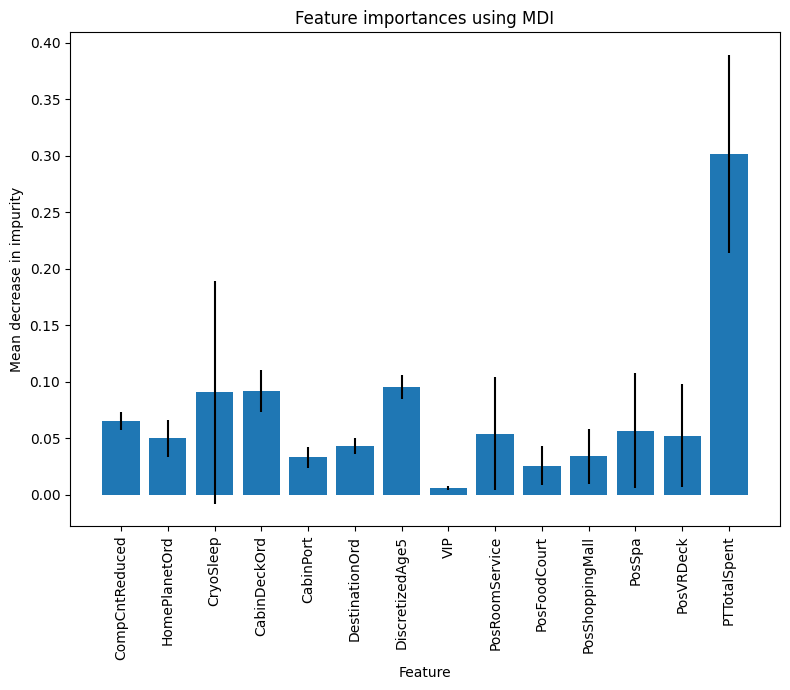

,Importance,Error
Feature,,
CompCntReduced,0.065409,0.008213
HomePlanetOrd,0.050048,0.016518
CryoSleep,0.090649,0.098453
CabinDeckOrd,0.092016,0.018661
CabinPort,0.033101,0.009024
DestinationOrd,0.043119,0.007092
DiscretizedAge5,0.095567,0.010398
VIP,0.005716,0.001681
PosRoomService,0.054094,0.050049


In [28]:
# Visualize results
# NOTE: Impurity-based feature importances can be misleading for high
# cardinality features (many unique values).

# Plot feature importances
fig = plt.figure(figsize=(8.0, 7.0), layout="tight")
ax = fig.add_subplot()
ax.bar(clf.feature_names_in_, importances, yerr=std)
ax.tick_params(axis="x", labelrotation=90.0)
ax.set_xlabel("Feature")
ax.set_ylabel("Mean decrease in impurity")
ax.set_title("Feature importances using MDI")
plt.show()

# Display results table
importances_df = pd.DataFrame(
    data={
        "Feature": clf.feature_names_in_,
        "Importance": importances,
        "Error": std,
    }
).set_index("Feature")
display(importances_df)

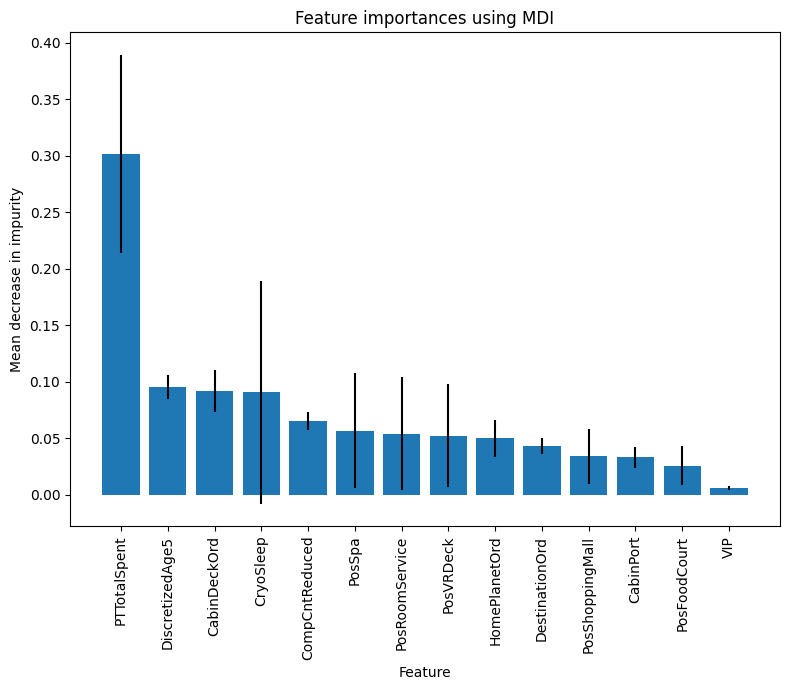

,Importance,Error
Feature,,
PTTotalSpent,0.301688,0.087821
DiscretizedAge5,0.095567,0.010398
CabinDeckOrd,0.092016,0.018661
CryoSleep,0.090649,0.098453
CompCntReduced,0.065409,0.008213
PosSpa,0.056563,0.051022
PosRoomService,0.054094,0.050049
PosVRDeck,0.052345,0.045636
HomePlanetOrd,0.050048,0.016518


In [29]:
# Same thing, but order by importance
importances_df = importances_df.sort_values(by="Importance", ascending=False)

fig = plt.figure(figsize=(8.0, 7.0), layout="tight")
ax = fig.add_subplot()
ax.bar(
    importances_df.index,
    importances_df["Importance"],
    yerr=importances_df["Error"],
)
ax.tick_params(axis="x", labelrotation=90.0)
ax.set_xlabel("Feature")
ax.set_ylabel("Mean decrease in impurity")
ax.set_title("Feature importances using MDI")
plt.show()

display(importances_df)

### Feature importance based on feature permutation

In [30]:
result = permutation_importance(
    clf,
    X_test,
    y_test,
    n_repeats=10,
    random_state=333,
    n_jobs=2,
)

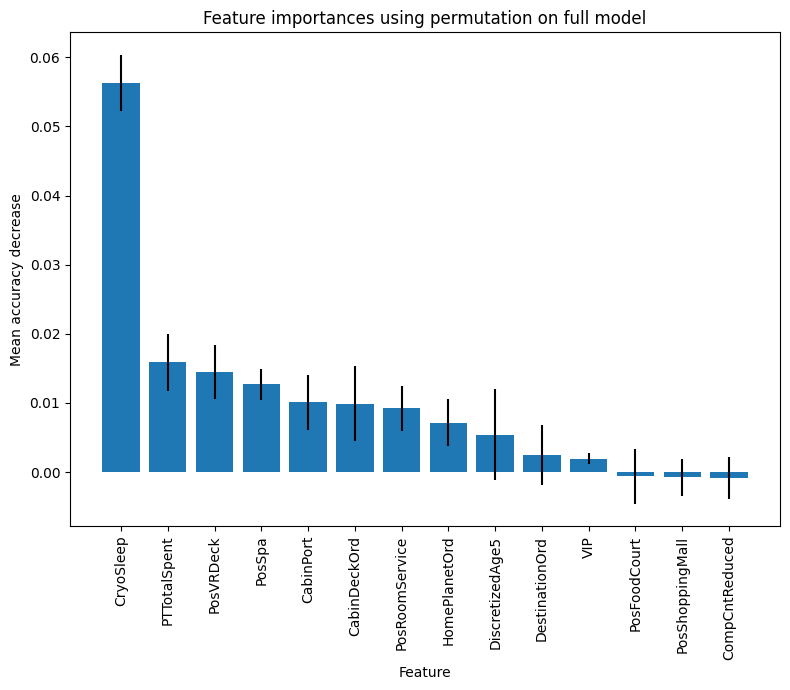

In [31]:
fig = plt.figure(figsize=(8.0, 7.0), layout="tight")
ax = fig.add_subplot()
idx = np.argsort(result.importances_mean)[::-1]
ax.bar(
    clf.feature_names_in_[idx],
    result.importances_mean[idx],
    yerr=result.importances_std[idx],
)
ax.tick_params(axis="x", labelrotation=90.0)
ax.set_xlabel("Feature")
ax.set_ylabel("Mean accuracy decrease")
ax.set_title("Feature importances using permutation on full model")
plt.show()